# Southern California Earthquake Data Center (SCEDC) Catalog [1]

"The Southern California Earthquake Data Center (SCEDC) is the archive of the Caltech/USGS Southern California Seismic Network (SCSN). It is funded by the U.S. Geological Survey (USGS) and the California Office of Emergency Services (CalOES). Its primary mission is to distribute data recorded or processed by the SCSN, a component of the California Integrated Seismic Network (CISN)." [1]

It has developed and maintained the standard earthquake catalog for Southern California since the Caltech Seismological Laboratory began routine operations in 1932. 

## Downloading the dataset

We begin by importing the neccessary dependencies

In [1]:
import pandas as pd
import numpy as np
import urllib.request
import shutil
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import math
from scipy.ndimage import uniform_filter1d
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('..')
from plot_utils import download_file, extract_tar_gz, combine_ascii_files, maxc, azimuthal_equidistant_projection
from scipy.stats import linregress

# Custom Colormap
colors = ["#5F0F40", "#C9DAEA", "#84A07C", "#E36414", "#39A9DB", "#0081A7", "#284B63", "#FFD449"]

The dataset can be downloaded from https://service.scedc.caltech.edu/ftp/catalogs/SCSN/.

In [2]:
# Define the URL and the local filename
url = "https://scedc.caltech.edu/ftp/catalogs/SCEC_DC/SCEDC_catalogs.tar.gz"
local_filename = "SCEDC_catalogs.tar.gz"
extract_path = "./"

# Download and extract the file
download_file(url, local_filename)
extract_tar_gz(local_filename, extract_path)
combine_ascii_files('./raw')

Downloaded SCEDC_catalogs.tar.gz
Extracted to ./
final file shape:  (908788, 12)
Merged dataset saved successfully as a CSV file.


We can now read the combined catalog.

In [3]:
raw_catalog = pd.read_csv("raw/SCEDC_catalog.csv")
raw_catalog['time'] = pd.to_datetime(raw_catalog['time'])
raw_catalog = raw_catalog.sort_values(by='time')
raw_catalog = raw_catalog[["time", "longitude", "latitude","magnitude"]].dropna()
raw_catalog.reset_index(drop=False, inplace=True)
print('the raw catalog has', len(raw_catalog),'events')

the raw catalog has 908788 events


## Visualising the Catalog

Let's plot events in the raw catalog over time along with an estimate of the completeness using Maximum Curvature [2]. We can see the improvements that were made to the network during the 1970s and 1980s.

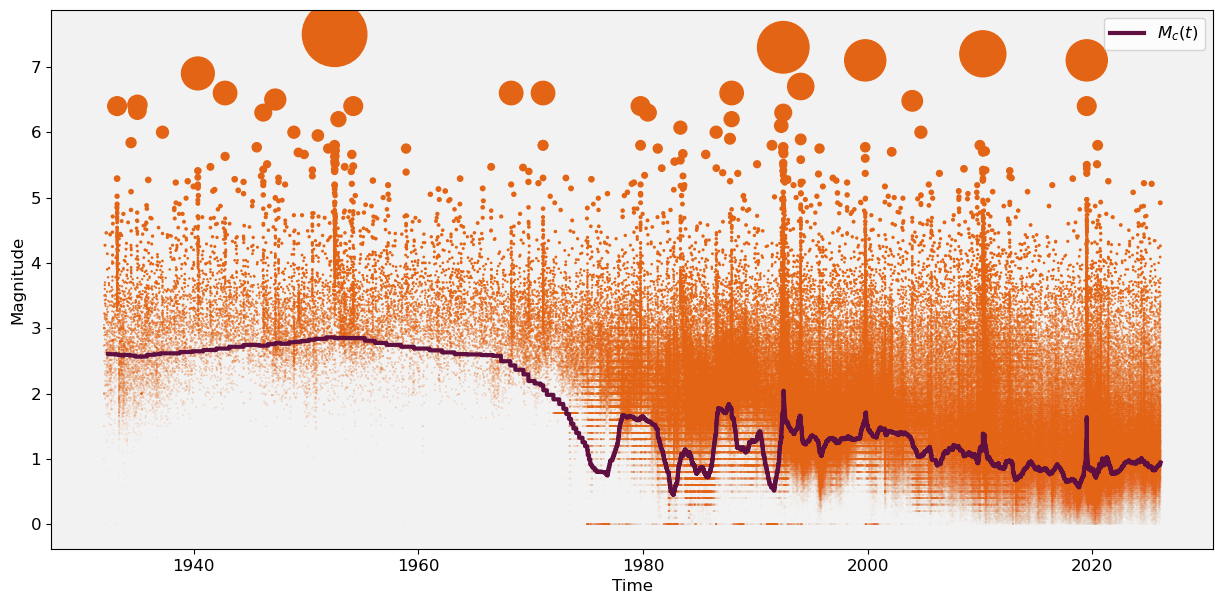

In [4]:
%matplotlib inline
plt.figure(figsize=(15, 7))
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Compute M_c(t) across the raw catalog
window_size=300
nwindows = math.floor(len(raw_catalog['magnitude'])/window_size)

Mc_t = [0]*nwindows
mid_time = [0]*nwindows

comp_T = raw_catalog['time']
comp_M = raw_catalog['magnitude']

for i in range(nwindows):
    
    mid_time[i] =  pd.Timestamp(pd.Series(comp_T[i*window_size:(i+1)*window_size]).mean())

    window = comp_M[i*window_size:(i+1)*window_size]
    Mc_t[i] = maxc(window,0.05)

# Smooth M_c(t) for plotting
Mc_t = uniform_filter1d(Mc_t, size=40)

# Plotting
plt.step(mid_time,Mc_t,colors[0],label=r'$M_c(t)$',lw=3)
z = (9.5**raw_catalog['magnitude'])*0.0001
plt.scatter(raw_catalog['time'],raw_catalog['magnitude'],s=z,color =colors[3])
plt.xlabel('Time',fontsize=12)
plt.ylabel('Magnitude',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

Let's now visualise the coordinates of the events in the catalog

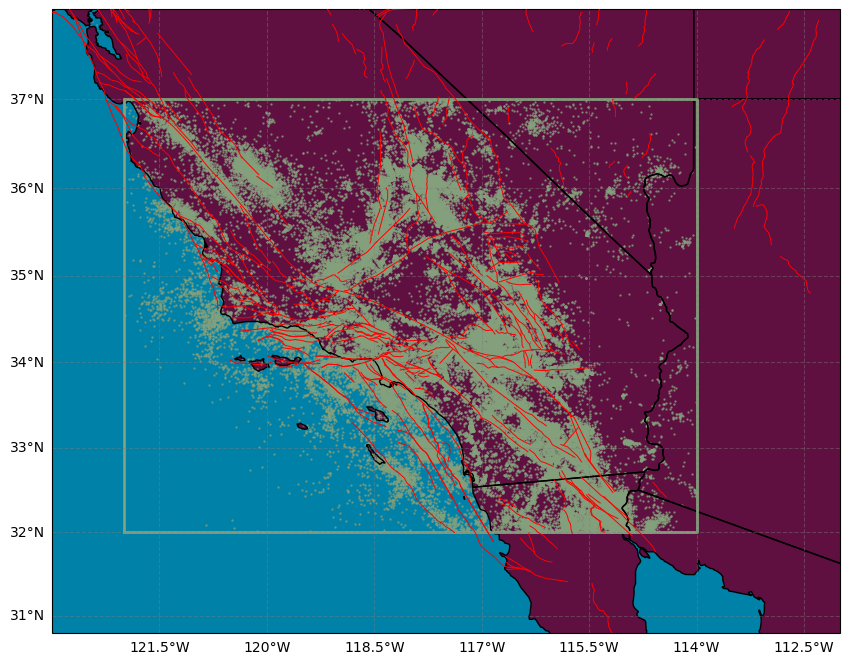

In [5]:
# Read the GEM fault data
gdf = gpd.read_file('/home/ss15859/Downloads/gem_active_faults.gpkg')
faults = gdf.geometry

# Filter the GeoDataFrame to include only geometries within the specified extent
max_lat, min_lat, max_lon, min_lon = 38, 30.79, -110, -130
filtered_gdf = gdf.cx[min_lon:max_lon, min_lat:max_lat]

# Extract the geometry of the faults within the specified extent
faults_within_extent = filtered_gdf.geometry


# Create a figure with Cartopy
fig = plt.figure(figsize=(10.5, 8.1))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([-123, -112, 30.79, 38], crs=ccrs.PlateCarree())

# Add colored land and ocean
ax.add_feature(cfeature.LAND, facecolor="#5F0F40")
ax.add_feature(cfeature.OCEAN, facecolor="#0081A7")
ax.add_feature(cfeature.STATES, edgecolor='black')


# Plot the faults
for geom in faults_within_extent:
    ax.plot(geom.xy[0], geom.xy[1], color='red', transform=ccrs.PlateCarree(),zorder=10,linewidth=0.7)


# Add gridlines with customization
gl = ax.gridlines(draw_labels=True, color='gray', linestyle='--', alpha=0.4)
gl.right_labels = False
gl.top_labels = False
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)


# Plot polygon
polygon_coords = np.load('SCEDC_shape.npy')
plot_polygon_coords = np.append(polygon_coords, [polygon_coords[0]], axis=0)
ax.plot(plot_polygon_coords[:, 1], plot_polygon_coords[:, 0], transform=ccrs.PlateCarree(), color=colors[2], lw=2)

plot_catalog = raw_catalog[raw_catalog['magnitude']>=1.8]
# Plot events
ax.scatter(plot_catalog['longitude'], plot_catalog['latitude'], transform=ccrs.PlateCarree(), s=0.4, color=colors[2], alpha=0.8)
plt.show()

## Truncating the catalog

For this catalog, we consider the whole region of events in the catalog, following the experiments by [3].

In [6]:
## filter events within polygon
poly = Polygon(polygon_coords)
gdf = gpd.GeoDataFrame(
    raw_catalog,
    geometry=gpd.points_from_xy(
        raw_catalog.latitude, raw_catalog.longitude),)

catalog = gdf[gdf.intersects(poly)].copy()
catalog.drop("geometry", axis=1, inplace=True)
len_trunc_x = len(catalog)
print('Removed',len(raw_catalog)-len_trunc_x, 'events outside polygon')

# filter events within timewindow
auxiliary_start = '1981-01-01 00:00:00'
test_nll_end = '2020-01-17 00:00:00'
catalog = catalog[catalog['time']>=auxiliary_start]
catalog = catalog[catalog['time']<test_nll_end]
len_trunc_t = len(catalog)
print('Removed',len_trunc_x-len_trunc_t, 'events outside timewindow')

Removed 0 events outside polygon
Removed 178290 events outside timewindow


For this catalog, follwing the etimation of completeness from [4] we take events from 1981 onwards above magnitude 2.0.

This estimation of completeness seems to agree with the point at which the Gutenberg-Richter law deviates from the magnitude-frequency histogram.

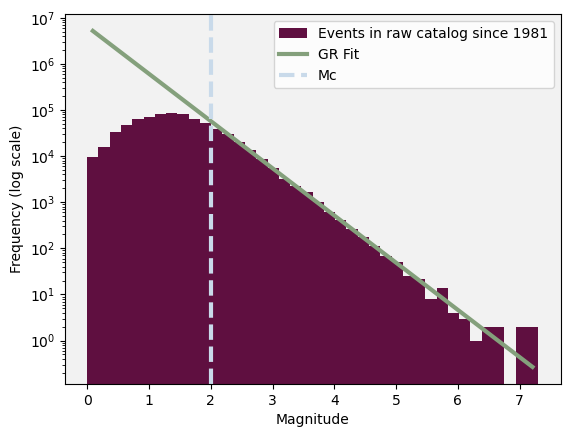

In [7]:
# plotting params
plt.figure()
plt.gca().set_facecolor((0.95, 0.95, 0.95))
bins = 40
linew = 3

# histogram
hist, bins = np.histogram(catalog['magnitude'], bins=bins)
log_hist = np.log10(hist[hist > 0])
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_centers = bin_centers[hist > 0]

plt.hist(catalog['magnitude'], bins=bins, log=True, alpha=1, color=colors[0], label='Events in raw catalog since 1981')
plt.xlabel(r'Magnitude')
plt.ylabel('Frequency (log scale)')

# Fit a GR line to the log-transformed histogram data
mag_bin = 0.05
mask = (bin_centers >= 2) & (bin_centers<=7)
slope, intercept, r_value, p_value, std_err = linregress(bin_centers[mask], log_hist[mask])
plt.plot(bin_centers, 10**(slope * bin_centers + intercept), 'r-',color = colors[2], label='GR Fit',linewidth=linew)
plt.axvline(x=2.0, color=colors[1], linestyle='--', label='Mc',linewidth=linew)

plt.legend()
plt.show()

Let's truncate the catalog above this threshold

In [8]:
# filter events above magnitude threshold
Mcut = 2
catalog = catalog[catalog['magnitude']>=Mcut]
len_trunc_m = len(catalog)
print('Removed',len_trunc_t-len_trunc_m, 'events below Mcut')

Removed 600074 events below Mcut


## Avoiding duplicated Locations

In [9]:
# # ============================Jittering Location of events=============================================
# set the random seed 
np.random.seed(42)

df_modified = catalog.copy()

# set the jettering range 
spatial_jitter_range = 0.005 # = 0.5km
time_jitter_range = 0.1/86400  

# deal with spatial duplication 
while True:
    duplicates = df_modified[df_modified.duplicated(subset=['longitude', 'latitude'], keep=False)]

    if duplicates.empty:
        print("no duplicate points found, finished!")
        break
    
    for idx in duplicates.index:
        df_modified.loc[idx, 'longitude'] += np.random.uniform(-spatial_jitter_range/2, spatial_jitter_range/2)
        df_modified.loc[idx, 'latitude'] += np.random.uniform(-spatial_jitter_range/2, spatial_jitter_range/2)

    print(f"there are {len(duplicates)} duplicate points, continue adding noise...")



while True:
    duplicates = df_modified[df_modified.duplicated(subset=['time'], keep=False)]

    if duplicates.empty:
        print("no duplicate time found, finished!")
        break
    
    for idx in duplicates.index:
        time_jitter = np.random.uniform(-time_jitter_range/2, time_jitter_range/2)
        df_modified.loc[idx, 'time'] += pd.to_timedelta(time_jitter, unit='s')

    print(f"there are {len(duplicates)} duplicate time, continue adding noise...")

df_modified.sort_values(by='time', inplace=True)

catalog = df_modified.copy()

there are 23685 duplicate points, continue adding noise...
no duplicate points found, finished!
there are 2 duplicate time, continue adding noise...
no duplicate time found, finished!


## The Processed Catalog

Let's now plot the truncated catalog, including the training, validation and testing windows. We can also label some of the major events that occurred.

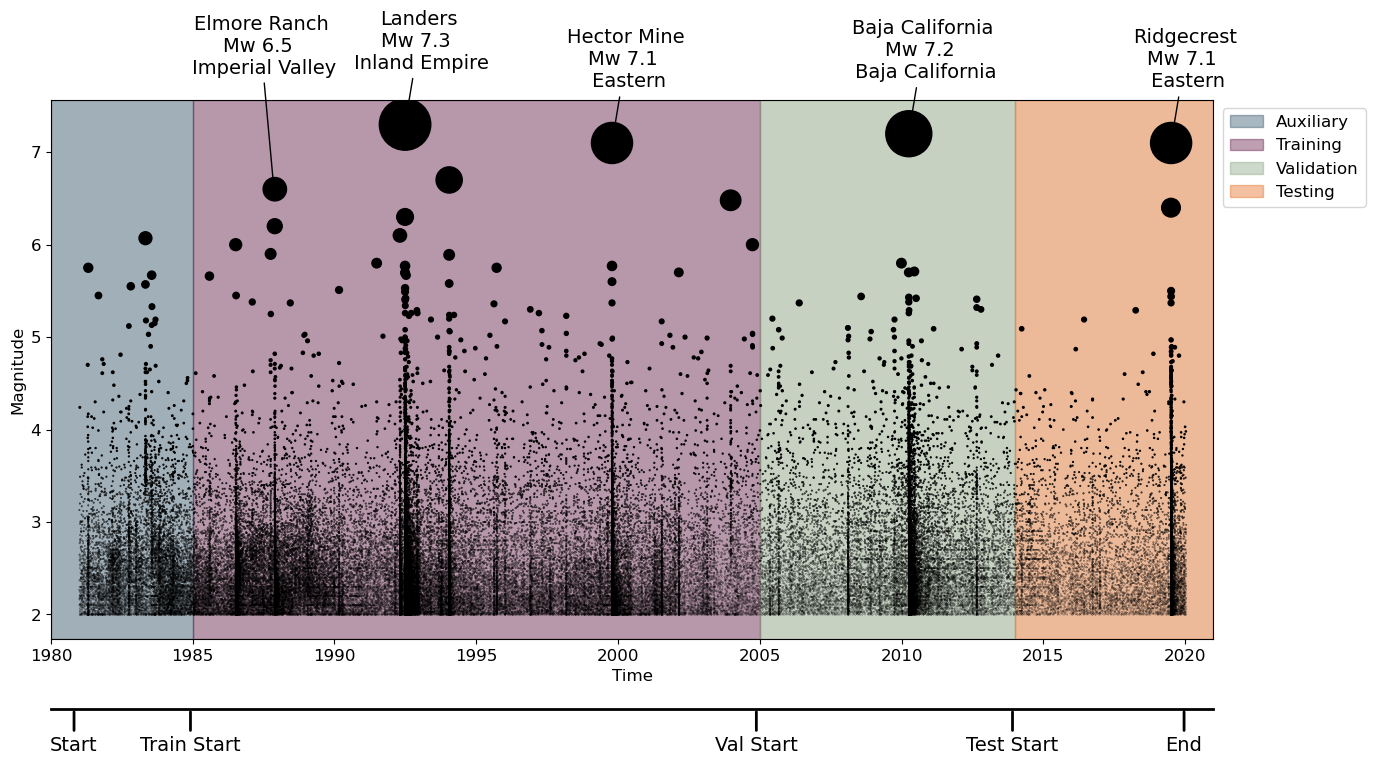

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# time windows for training, validation, and testing
auxiliary_start = pd.Timestamp('1981-01-01 00:00:00')
training_start = pd.Timestamp('1985-01-01 00:00:00')
validation_start = pd.Timestamp('2005-01-01 00:00:00')
testing_start = pd.Timestamp('2014-01-01 00:00:00')
testing_end = pd.Timestamp('2020-01-01 00:00:00')

# Plotting
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_facecolor((0.95, 0.95, 0.95))

# Plotting earthquakes
z = (9.5 ** catalog['magnitude']) * 0.0001
scatter = ax.scatter(catalog['time'], catalog['magnitude'], s=z, color='black')

xmin, xmax = pd.Timestamp('1980-01-01'), pd.Timestamp('2021-01-01')
ax.set_xlim(xmin, xmax)

# Highlighting time windows
alph = 0.4
ax.axvspan(xmin, training_start, color=colors[6], alpha=alph, label='Auxiliary', zorder=-100)
ax.axvspan(training_start, validation_start, color=colors[0], alpha=alph, label='Training', zorder=-100)
ax.axvspan(validation_start, testing_start, color=colors[2], alpha=alph, label='Validation', zorder=-100)
ax.axvspan(testing_start, xmax, color=colors[3], alpha=alph, label='Testing', zorder=-100)

trans = ax.get_xaxis_transform()
lineheight, textheight = -.13, -.18

# Annotations for train/val/test windows
annotations = [
    ('Start', 3950),
    ('Train Start', 5450),
    ('Val Start', 12740),
    ('Test Start', 16040),
    ('End', 18250),
]

for label, x_pos in annotations:
    ax.annotate(
        label, xy=(x_pos, lineheight), xycoords=trans, ha="center", va="top", fontsize=14,
        xytext=(x_pos, textheight), textcoords=trans, arrowprops=dict(arrowstyle='-', color='black', lw=2)
    )

ax.plot([xmin, xmax], [lineheight, lineheight], color="k", transform=trans, clip_on=False, lw=2)

# Event annotations
events = [
    ('1992-06-28', 'Landers', 'Inland Empire', '7.3'),
    ('1999-10-16', 'Hector Mine', 'Eastern', '7.1'),
    ('2010-04-04', 'Baja California', 'Baja California', '7.2'),
    ('2019-07-05', 'Ridgecrest', 'Eastern', '7.1'),
    ('1987-11-24','Elmore Ranch','Imperial Valley','6.5'),
]

for date, name, location, magnitude in events[:-1]:
    event_date = pd.Timestamp(date)
    magnitude = float(magnitude)
    ax.annotate(
        f'{name}\nMw {magnitude} \n {location}',
        xy=(event_date, magnitude),
        xytext=(10, 40),
        textcoords='offset points',
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        fontsize=14,
        ha='center'
    )
ax.annotate(
        f'{events[-1][1]}\nMw {events[-1][3]} \n {events[-1][2]}',
        xy=(pd.Timestamp(events[-1][0]), float(events[-1][3])),
        xytext=(-10, 90),
        textcoords='offset points',
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        fontsize=14,
        ha='center'
    )

# Labels and formatting
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Magnitude', fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(loc='upper left', bbox_to_anchor=(1.001, 1), fontsize=12)

plt.show()

Finally, since ETAS uses the great-circle distance between two points on a sphere (km), for the NPPs we need to project the coordinates of the events into a space such that inter-event distances are in km. To do this, we can use the Azimuthal equidistant projection [5], which preserves distances from all points to a center point.

We pass the mean coordinates of the catalog as the center coordinates of the projection.

In [11]:
center_latitude = catalog['latitude'].mean()  # Latitude of the center point
center_longitude = catalog['longitude'].mean()  # Longitude of the center point

# Convert latitude and longitude to Cartesian coordinates using Plate Carrée projection
catalog['x'], catalog['y'] = azimuthal_equidistant_projection(catalog['latitude'], catalog['longitude'], center_latitude, center_longitude)

Finally, we can write this pre-processed catalog to file.

In [12]:
catalog.to_csv("SCEDC_catalog.csv", index=False)

## References

[1]: Center, E. (2013). Southern California earthquake center. Caltech. Dataset. doi:10.7909/C3WD3xH1

[2]: Wiemer, S., & Wyss, M. (2000). Minimum magnitude of completeness in earthquake catalogs: Examples from Alaska, the western United States, and Japan. Bulletin of the Seismological Society of America, 90(4), 859-869.

[3]: Dascher-Cousineau, K., Shchur, O., Brodsky, E. E., & Günnemann, S. (2023). Using deep learning for flexible and scalable earthquake forecasting. Geophysical Research Letters, 50, e2023GL103909. https://doi.org/10.1029/2023GL103909

[4]: Hutton, K., Woessner, J., & Hauksson, E. (2010). Earthquake monitoring in southern California for seventy-seven years (1932–2008). Bulletin of the Seismological Society of America, 100(2), 423-446.

[5]: Bradley, A. D. (1945). Azimuthal Equidistant Projection of the Sphere. The American Mathematical Monthly, 52(3), 148-151.